# <center> PTC

### Measurement configuration settings

<hr>
<div class="alert alert-block alert-success">
<b>Remark:</b> Please write the desired values below from the following possibilities: 
    <br> If the parameter is optional, you can write None and it will take a default value
</div>

| Parameter | <p style="text-align: left"> Possible values </p> | Datatype | Comments |
| --- | --- | --- | --- |
| sensor_name | <p style="text-align: left"> 'Mira030', 'Mira050', 'Mira130', 'Mira220' </p> | str | sensor product |
| port | <p style="text-align: left"> 0, 1 </p> | int | CSI port on nvidia 0 is closest to the power supply |
| bit_mode (optional) | <p style="text-align: left"> Mira030: 8bit, 10bit, 12bit <br> Mira050: 8bit, 10bit, 10bithighspeed, 12bit <br> Mira130: 8bit, 10bit <br> Mira220: 8bit, 10bit, 12bit </p> | str | bit depth for a pixel |
| fps (optional) | <p style="text-align: left"> Mira030: 1 - 180 <br> Mira050: 60 <br> Mira130: 30 <br> Mira220: 5 - 90 </p> | float | frame rate |
| w (optional) | <p style="text-align: left"> Mira030: 640 <br> Mira050: 600 <br> Mira130: 1080 <br> Mira220: 1600 </p> | int | width/amount of columns |
| h (optional) | <p style="text-align: left"> Mira030: 480 <br> Mira050: 800 <br> Mira130: 1280 <br> Mira220: 1400 </p> | int | height/amount of rows |
| analog_gain (optional) | <p style="text-align: left"> Mira030: 1- 15.5 <br> Mira050: 1, 2, 4 <br> Mira130: 1 - 28.547 <br> Mira220: 1</p> | int/float | analog gain |
| illum_pcb | <p style="text-align: left"> True, False </p> | bool | 940nm led on the PCB or your own light source |
| roi_process_w | <p style="text-align: left"> smaller than w </p> | int | width/amount of columns to use in calculations |
| roi_process_h | <p style="text-align: left"> smaller than h </p> | int | height/amount of rows to use in calculations |
| guard_banded | <p style="text-align: left"> bigger than 1 </p> | int | extra increase of found saturation exposure time |
| nb_imgs | <p style="text-align: left"> bigger than 0 </p> | int | number of image per exposure step |
| method_exp | <p style="text-align: left"> 'evenly_lin', 'evenly_log', 'multiple_lin' </p> | str | method of distributing the exposure points |
| exp_steps | <p style="text-align: left"> bigger than 0 </p> | int | number of exposure steps between dark and full saturation |
| nb_intervals | <p style="text-align: left"> bigger than 1 </p> | int | number of intervals for distributing the exposure points |
| percentages_intervals | <p style="text-align: left"> [int, int, ...] </p> | list | number of points per interval in percentage for distributing the exposure points |
| points_intervals | <p style="text-align: left"> [int, int, ...]  </p> | list | start and stop points used for the intervals for distributing the exposure points |
| save_notebook_to_html | <p style="text-align: left"> True, False </p> | bool | save notebook outputs an html |
| notebook_name | <p style="text-align: left"> 'plotter_ptc' </p> | str | this notebook name to save to an html |
| save_results_to_excel | <p style="text-align: left"> True, False </p> | bool | save tables to excel (data also present in html) |
| save_images | <p style="text-align: left"> True, False </p> | bool | save taken images to disk |
| grab_new_image_data | <p style="text-align: left"> True, False </p> | bool | perform ptc sweep or use stored dataset |

***

In [1]:
sensor_name = 'Mira220'
port = 0
################################
bit_mode = None #'12bit'
fps = None #30
w = None #1600
h = None #1400
analog_gain = None #1
################################
illum_pcb = False
roi_process_w = 150
roi_process_h = 200
guard_banded = 1.15
nb_imgs = 30
################################
method_exp = 'evenly_lin'
exp_steps = 8
nb_intervals = 2
percentages_intervals = [50, 50]
points_intervals = [0, 30, 100]
################################
save_notebook_to_html = False
notebook_name = 'plotter_ptc'
save_results_to_excel = False
save_images = False
grab_new_image_data = True

### Imports

In [2]:
import cv2
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import time
import os
import sys
import pickle
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import h5py
import characterization_ams.stats_engine.stats as stats
import characterization_ams.emva.emva as emva
import characterization_ams.standard_tests.ptc as ptc

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(os.path.dirname(os.getcwd()))
from ams_jetcis.scripts import sensor_script_example as scripts
import ams_jetcis.scripts.plotter as plotter

import plotly.io as pio
pio.renderers.default = 'jpg'

### Exposure steps

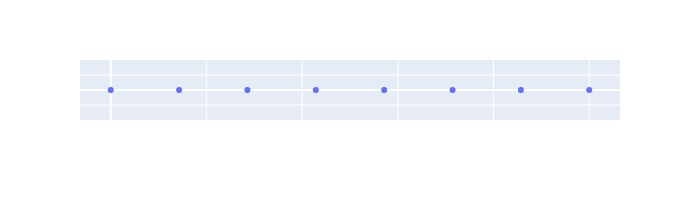

In [3]:
exp_cfg = scripts.generate_exp_points(method_exp, exp_steps, 
                                      {'nb_intervals':nb_intervals,
                                       'percentages':percentages_intervals, 
                                       'points':points_intervals})

fig = px.scatter(x=exp_cfg, y=np.zeros(len(exp_cfg)), height=200)
fig.update_layout(xaxis=go.layout.XAxis(showticklabels=False), yaxis=go.layout.YAxis(showticklabels=False))
fig.show()

### Get image data

In [4]:
select_sensor_params = {'sensor_name': sensor_name, 'port': port}
init_sensor_params_temp = {'bit_mode' : bit_mode, 'fps' : fps, 'w' : w, 'h' : h, 'analog_gain' : analog_gain}
init_sensor_params = {k: v for k, v in init_sensor_params_temp.items() if v is not None}
sensor = scripts.select_sensor(**select_sensor_params)
sensor.cold_start()
sensor.init_sensor(**init_sensor_params)

Open card:
Current sensor loaded: mira220
Current jetpack loaded: 4.6
Current kernel loaded: Linux-4.9.253-tegra-aarch64-with-Ubuntu-18.04-bionic
Correct sensor driver loaded
Reset sensor low
Reset sensor high 
Mira220 detected with ID 01:0C:2D:05:0B:04:E5:07


In [5]:
datestr = datetime.now().strftime('_%m-%d-%Y_%H%M%S')

Turn on your illumination. Press enter to continue...


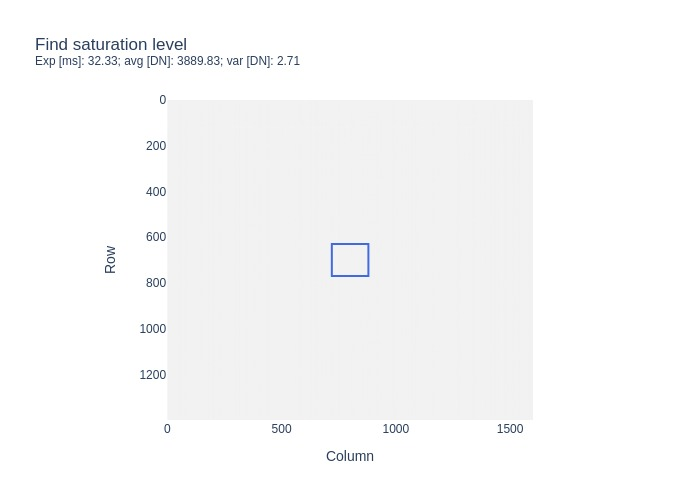

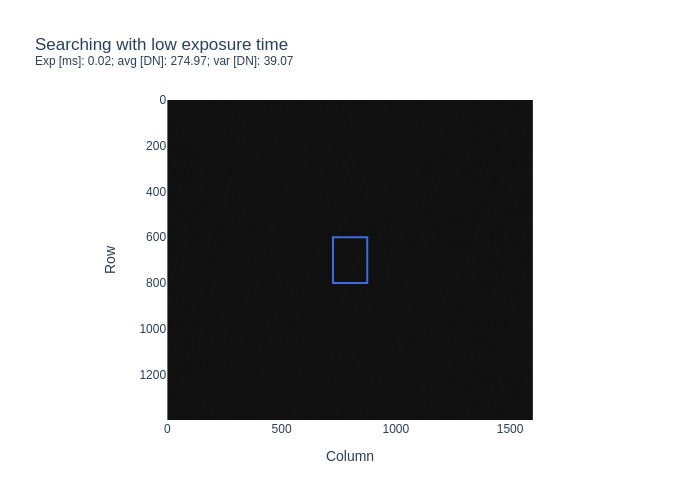

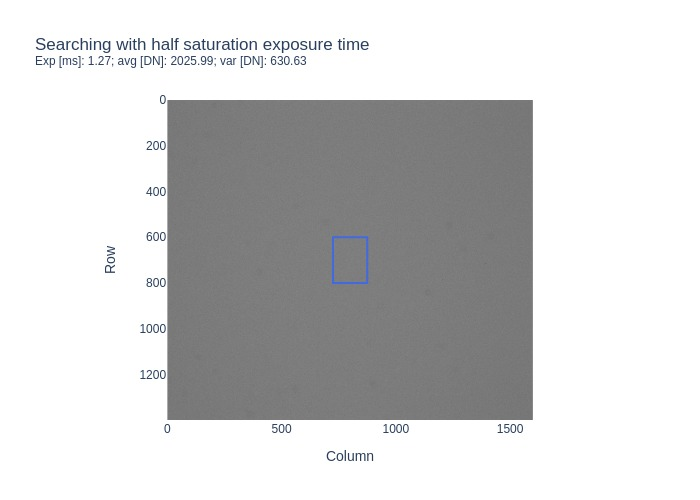

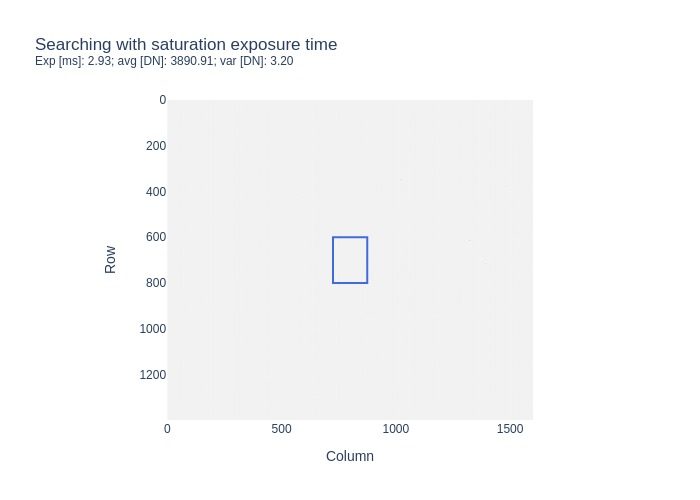

Saturation exposure time [ms]: 2.928

Exposure sweep: [    7.8125       425.03386795   842.2552359   1259.47660385  1676.69797181
  2093.91933976  2511.14070771  2928.36207566]

Acquiring dark image series
Turn off your illumination and cover the sensor. Press enter to continue...
Dark exposure [ms]: 0.008, avg [DN]: 208.118, var [DN]: 5.560

Acquiring grey image series
Turn on your illumination and uncover the sensor. Press enter to continue...


  0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
if grab_new_image_data:
    # Find saturation exposure
    if illum_pcb:
        scripts.config_illum_trigger_from_exp(sensor, 1e6 / sensor.fps - 5e3)
        currents = [220, 280, 350, 410, 470, 530, 590, 650, 710, 770, 830, 890, 950, 1010]
        for current in currents:
            try:
                sensor.led_driver = [True, current, 1100]
                exp_max = scripts.find_sat_exposure_time(sensor, guard_banded, roi_process_w, roi_process_h)
                break
            except:
                if current == 1010:
                    raise Exception(f'Error: Cannot saturation. Please check your illumination, take a smaller processing ROI or bring your sensor closer to the reflection surface.')
                else:
                    print('Increasing the illumination current...')
        scripts.config_illum_trigger_from_exp(sensor, exp_max)
    else:
        input('Turn on your illumination. Press enter to continue...')
        while True:
            try:
                exp_max = scripts.find_sat_exposure_time(sensor, guard_banded, roi_process_w, roi_process_h)
                break
            except:
                input('Increase your illumination power. Press enter to continue...')
    print(f'Saturation exposure time [ms]: {exp_max/1e3:.3f}\n')


    # Set exposure time
    min_exp = sensor.get_exposure_limit()['min_exp_time']
    exposure_times = (exp_cfg / exp_cfg[-1] * (exp_max - min_exp)) + min_exp
    print(f'Exposure sweep: {exposure_times}')

    
    # Create hdf5 file to store images and/or data
    results_path = f'{os.getcwd()}/results{datestr}/'
    if not os.path.exists(results_path):
        os.makedirs(results_path)
     

    # Acquire dark series (only 1 implemented)
    print('\nAcquiring dark image series')
    if illum_pcb:
        sensor.led_driver = [False, None, None]
        input('Cover the sensor. Press enter to continue...')
    else:
        input('Turn off your illumination and cover the sensor. Press enter to continue...')

    sensor.exposure_us = exposure_times[0]
    exposure_time_dark_actual = sensor.exposure_us / 1e3
    dark_imgs = sensor.imager.grab_images(nb_imgs)
    dark_imgs = scripts.apply_process_roi(dark_imgs, roi_process_w, roi_process_h)
    data = ptc.get_stats([dark_imgs], pd.DataFrame([exposure_time_dark_actual], columns=['Exposure time [ms]']),
                         rmv_ttn=False, hpf=False)
    
    with h5py.File(results_path + 'ptc.hdf5','w') as h5py_file:
        h5py_file.attrs['Measurement'] = 'PTC'
        h5py_file.create_dataset('dark_imgs', data=dark_imgs, compression='lzf')
    print(f'Dark exposure [ms]: {exposure_time_dark_actual:.3f}, avg [DN]: {np.mean(dark_imgs):.3f}, var [DN]: {stats.total_var_temp(dark_imgs):.3f}')


    # Acquire light series
    print('\nAcquiring grey image series')
    if illum_pcb:
        sensor.led_driver = [True, None, None]
        input('Uncover the sensor. Press enter to continue...')
    else:
        input('Turn on your illumination and uncover the sensor. Press enter to continue...')

    exposure_times_actual = []
    light_avg_imgs = []
    light_ttn_vars = []
    pbar = tqdm(exposure_times)
    for exposure_time in pbar:
        sensor.exposure_us = exposure_time
        exposure_times_actual.append(sensor.exposure_us / 1e3)
        time.sleep(1)

        imgs = sensor.imager.grab_images(nb_imgs)
        imgs = scripts.apply_process_roi(imgs, roi_process_w, roi_process_h)

        light_avg_img = stats.avg_img_stack(imgs)
        light_avg_imgs.append(light_avg_img)

        light_ttn_var = stats.total_var_temp(imgs)
        light_ttn_vars.append(light_ttn_var)

        temp = ptc.get_stats([dark_imgs, imgs], 
                             pd.DataFrame([exposure_time_dark_actual, exposure_times_actual[-1]], 
                                          columns=['Exposure time [ms]']),
                             rmv_ttn=False, hpf=False)
        data = data.append(temp.iloc[1: , :])
        
        if save_images:
            with h5py.File(results_path + 'ptc.hdf5','a') as h5py_file:
                g = h5py_file.create_group(f'EXP_{exposure_times_actual[-1]:.5f}'.replace('.', '_'))
                g.attrs['exposure_time'] = exposure_times_actual[-1]
                g.create_dataset('imgs', data=imgs, compression='lzf')
        
        pbar.set_postfix_str(f'exposure [ms]: {exposure_times_actual[-1]:.3f}, avg [DN]: {np.mean(light_avg_img):.3f}, var [DN]: {light_ttn_var:.3f}')

    data.reset_index(drop=True, inplace=True)
    
    with h5py.File(results_path + 'ptc.hdf5','a') as h5py_file:
        h5py_file.create_dataset('light_avg_imgs', data=light_avg_imgs, compression='lzf')
        h5py_file.create_dataset('light_ttn_vars', data=light_ttn_vars, compression='lzf')
        h5py_file.create_dataset('data', data=data.to_records(index=False), compression='lzf')

    del imgs, light_avg_img
    sensor.led_driver = [False, None, None]
    
else:
    # Load data from hdf5 file
    dir_name = input('Give the directory name. Press enter to continue...')
    with h5py.File(f'{os.getcwd()}/{dir_name}/ptc.hdf5', 'r') as f:
        dark_imgs = np.array(f['dark_imgs'])
        light_avg_imgs = list(f['light_avg_imgs'])
        light_ttn_vars = list(f['light_ttn_vars'])
        data = pd.DataFrame.from_records(f['data'][...])

    # Load images, find exposure name in keys or use exposure from data column
#     with h5py.File(results_path + 'ptc.hdf5', 'r') as f:
#         list(f.keys())
#         np.array(f['EXP_2_45442']['imgs'])

### PTC stats

In [7]:
data, hist, profiles, spect, summ, prnu_img = ptc.ptc_mem_optimized(dark_imgs,
                                                                    light_avg_imgs,
                                                                    light_ttn_vars,
                                                                    data,
                                                                    exp_col='Exposure time [ms]',
                                                                    exp_col_units=['uW/cm^2'])
dark_avg_img = stats.avg_img_stack(dark_imgs)
dark_std_img = np.sqrt(stats.tot_var_img_stack(dark_imgs))

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning:

'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning:

'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.

/home/jetcis/.local/lib/python3.6/site-packages/characterization_ams/emva/emva.py:751: RuntimeWarning:

divide by zero encountered in log10

/home/jetcis/.local/lib/python3.6/site-packages/characterization_ams/emva/emva.py:829: RuntimeWarning:

divide by zero encountered in log10

/home/jetcis/.local/lib/python3.6/site-packages/characterization_ams/emva/emva.py:888: RuntimeWarning:

divide by zero encountered in log10



In [8]:
summ.T

,0
System Gain [DN/e],0.395851
Conversion Factor [e/DN],2.526202
Dark Noise [DN],2.340294
Dark Noise [e],5.912057
Col Temp Noise [e],0.936537
Row Temp Noise [e],1.367037
Pix Temp Noise [e],5.741007
Col DSNU [DN],0.300664
Pix DSNU [DN],2.054650
Row DSNU [DN],0.452707


In [9]:
data

,Col Var [DN^2],Col Temp Var [DN^2],Mean Signal [DN],Pix Var [DN^2],Pix Temp Var [DN^2],Row Var [DN^2],Row Temp Var [DN^2],Tot Var [DN^2],Tot Temp Var [DN^2],CFPN Ratio,CTN Ratio,RFPN Ratio,RTN Ratio,STN Ratio,Tot FPN [%],Pix FPN [%],Col FPN [%],Row FPN [%],Exposure time [ms],Col Var - Col Dark Var [DN^2],Col Temp Var - Col Dark Temp Var [DN^2],Signal - Dark [DN],Pix Var - Pix Dark Var [DN^2],Pix Temp Var - Pix Dark Temp Var [DN^2],Row Var - Row Dark Var [DN^2],Row Temp Var - Row Dark Temp Var [DN^2],Tot Var - Tot Dark Var [DN^2],Tot Temp Var - Tot Dark Temp Var [DN^2],System Gain Fit [DN^2],Tot Var [e^2],Col Var [e^2],Row Var [e^2],Pix Var [e^2],Tot Temp Var [e^2],Col Temp Var [e^2],Row Temp Var [e^2],Pix Temp Var [e^2],Mean Signal [e],Tot Var - Tot Dark Var [e^2],Col Var - Col Dark Var [e^2],Row Var - Row Dark Var [e^2],Pix Var - Pix Dark Var [e^2],Tot Temp Var - Tot Dark Temp Var [e^2],Col Temp Var - Col Dark Temp Var [e^2],Row Temp Var - Row Dark Temp Var [e^2],Pix Temp Var - Pix Dark Temp Var [e^2],Signal - Dark [e],Linearity Fit [DN],Linearity Error [%],Linearity Error [DN],Responsivity Fit [DN],SNR [dB],SNR [ratio],SNR Ideal [dB],SNR Ideal [ratio],SNR Theoretical [dB],SNR Theoretical[ratio]
0,0.113795,0.137440,208.117726,4.281330,5.164638,0.301168,0.292836,4.667608,5.560311,6.990160,6.360520,4.296797,6.360520,0.916216,1.038097,0.994215,0.162089,0.263691,0.007812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.563860,29.787266,0.726208,1.921966,27.322155,35.484222,0.877102,1.868791,32.959161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,27.132185,NaN,NaN,NaN,NaN,NaN,NaN
1,0.087555,0.125792,256.709472,6.409517,28.383020,0.347733,0.351978,6.801860,28.670620,18.095807,15.097023,9.080207,15.097023,0.487074,1.015949,0.986213,0.115265,0.229711,0.007812,-0.026240,-0.011648,48.591747,2.128187,23.218382,0.046564,0.059142,2.134252,23.110309,29.798957,43.407418,0.558750,2.219125,40.903604,182.967233,0.802769,2.246215,181.131863,122.752581,13.620152,-0.167458,0.297159,13.581449,147.483011,-0.074333,0.377424,148.172702,122.752581,48.619314,-0.056700,-0.027567,27.132185,19.789839,9.760947,20.890306,11.079376,20.668107,10.799542
2,0.450133,0.305001,863.653813,35.599946,312.078605,0.712240,0.527471,36.523794,310.820098,26.277505,31.923015,20.890142,31.923015,0.342794,0.699759,0.690852,0.077684,0.097718,0.421875,0.336338,0.167561,655.536088,31.318616,306.913967,0.411071,0.234634,31.856185,305.259787,270.058554,233.083819,2.872613,4.545300,227.188105,1983.559977,1.946424,3.366158,1991.591391,1656.016757,203.296553,2.146405,2.623334,199.865950,1948.075755,1.069323,1.497366,1958.632230,1656.016757,649.664278,0.903822,5.871810,644.295888,31.954211,39.601403,32.190647,40.694186,32.173781,40.615242
3,1.016280,0.388316,1475.654339,71.275099,502.119168,1.331636,0.788033,73.145460,499.931234,22.179336,35.880837,19.375921,35.880837,0.382506,0.579574,0.572116,0.068316,0.078200,0.843750,0.902484,0.250876,1267.536613,66.993769,496.954529,1.030468,0.495197,68.477852,494.370923,512.319648,466.792231,6.485589,8.498100,454.856155,3190.410127,2.478115,5.028989,3204.372858,3202.053878,437.004965,5.759381,6.576133,427.534000,3154.925905,1.601013,3.160198,3171.413697,3202.053878,1262.049713,0.434761,5.486901,1273.104189,34.727384,54.496574,35.054286,56.586693,35.045555,56.529841
4,1.652451,0.352284,2066.937603,109.927465,643.598829,2.159440,0.833692,113.002824,640.472585,19.687291,42.638664,17.221846,42.638664,0.420044,0.514301,0.507254,0.062192,0.071096,1.257812,1.538656,0.214844,1858.819878,105.646135,638.434191,1.858272,0.540856,108.335216,634.912275,NaN,721.149889,10.545444,13.780894,701.523879,4087.302580,2.248172,5.320369,4107.253325,4695.755007,691.362623,9.819236,11.858928,674.201723,4051.818358,1.371071,3.451577,4074.294164,4695.755007,1863.094677,-0.229446,-4.274799,NaN,36.279309,65.157657,36.717054,68.525579,36.711099,68.478610
5,2.494585,1.815518,2658.5782

### Plot results

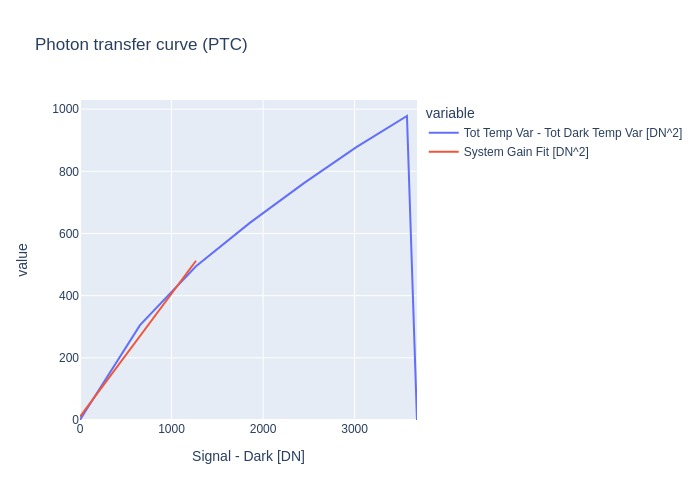

In [10]:
fig = px.line(data, x='Signal - Dark [DN]', y=['Tot Temp Var - Tot Dark Temp Var [DN^2]','System Gain Fit [DN^2]'], 
              title='Photon transfer curve (PTC)')
fig.update_xaxes(rangemode="nonnegative")
fig.update_yaxes(rangemode="nonnegative")
fig.show()

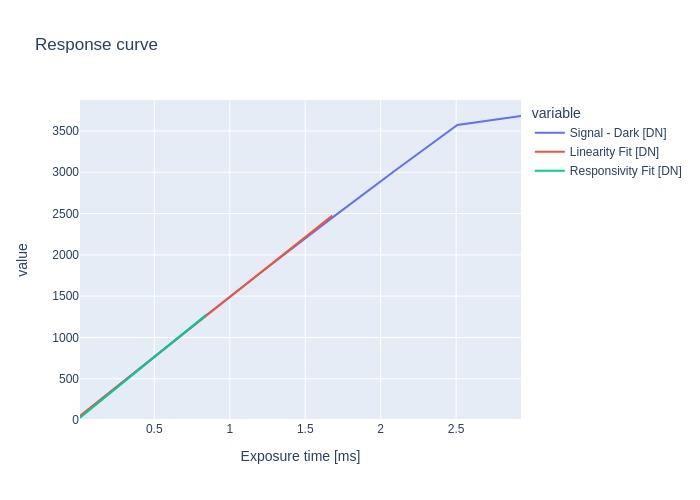

In [11]:
fig = px.line(data.iloc[1: , :], x='Exposure time [ms]', y=['Signal - Dark [DN]', 
                                                            'Linearity Fit [DN]', 
                                                            'Responsivity Fit [DN]'], 
              title='Response curve')
fig.update_xaxes(rangemode="nonnegative")
fig.update_yaxes(rangemode="nonnegative")
fig.show()

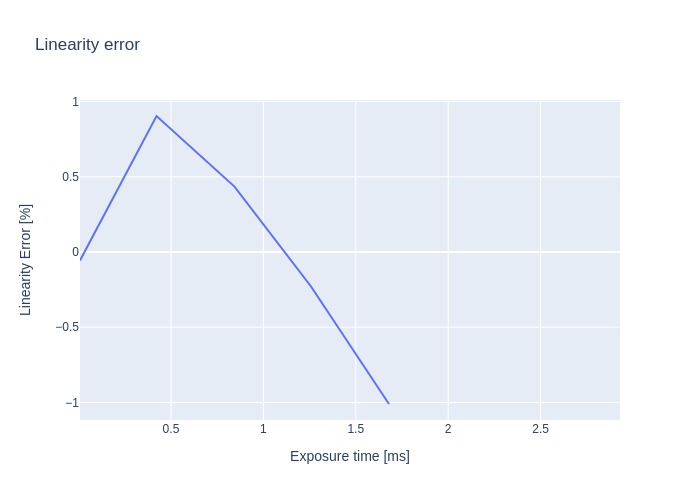

In [12]:
fig = px.line(data.iloc[1: , :], x='Exposure time [ms]', y='Linearity Error [%]', 
              title='Linearity error')
fig.show()

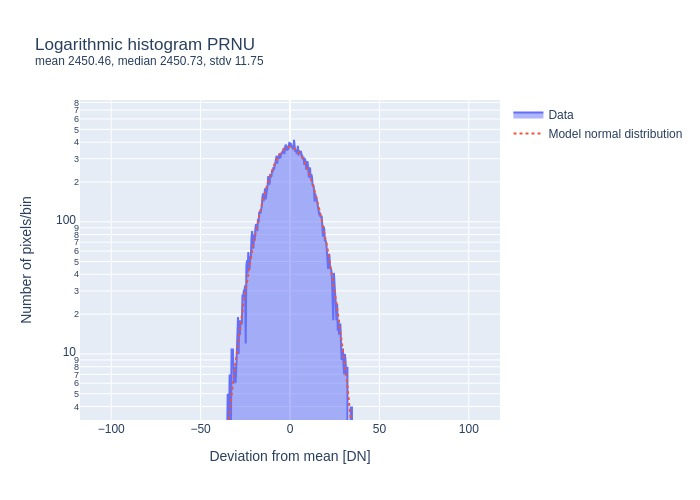

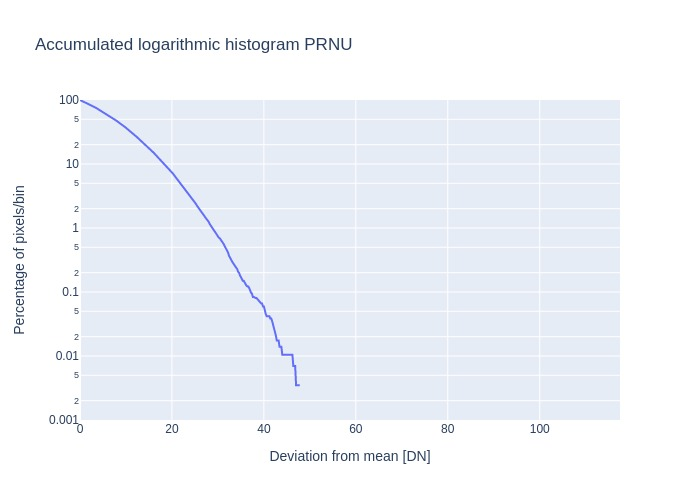

In [13]:
plotter.histogram(prnu_img, hist['PRNU1288'], 
                  title='PRNU', 
                  unit='DN',
                  nb_limit_std=10)

plotter.accumulated_histogram(prnu_img, hist['PRNU1288'], 
                              title='PRNU', 
                              unit='DN',
                              nb_limit_std=10)

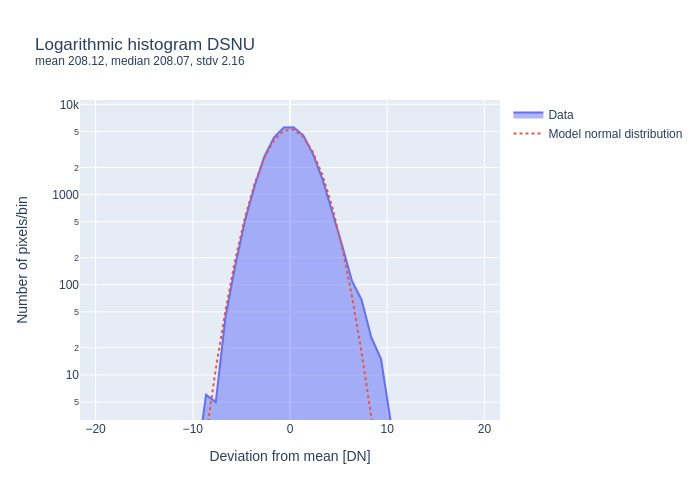

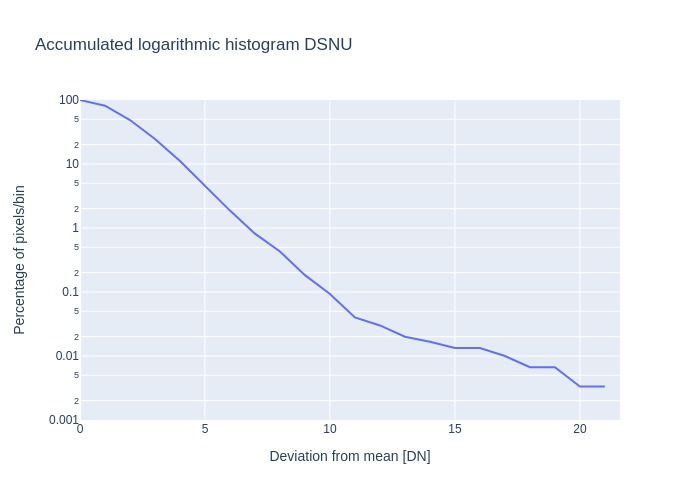

In [14]:
plotter.histogram(dark_avg_img, hist['DSNU1288'], 
                  title='DSNU', 
                  unit='DN',  
                  nb_limit_std=10)

plotter.accumulated_histogram(dark_avg_img, hist['DSNU1288'], 
                              title='DSNU', 
                              unit='DN',  
                              nb_limit_std=10)

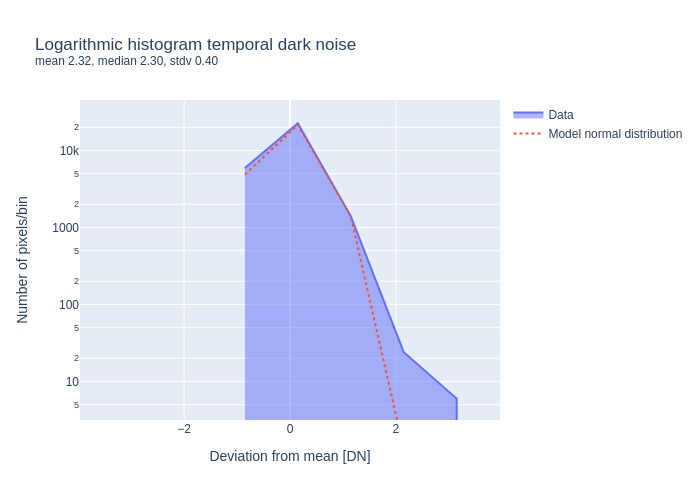

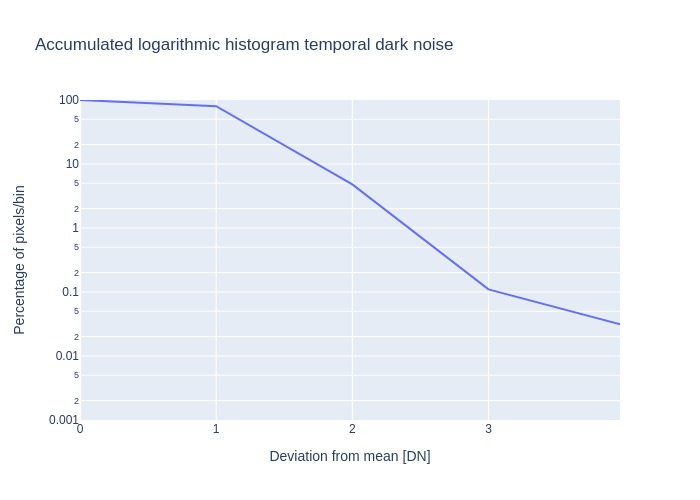

In [15]:
hist_tdn = emva.histogram1288(dark_std_img, 256, nb_imgs, black_level=True)

plotter.histogram(dark_std_img, hist_tdn, 
                  title='temporal dark noise', 
                  unit='DN', 
                  nb_limit_std=10)

plotter.accumulated_histogram(dark_std_img, hist_tdn, 
                              title='temporal dark noise', 
                              unit='DN', 
                              nb_limit_std=10)

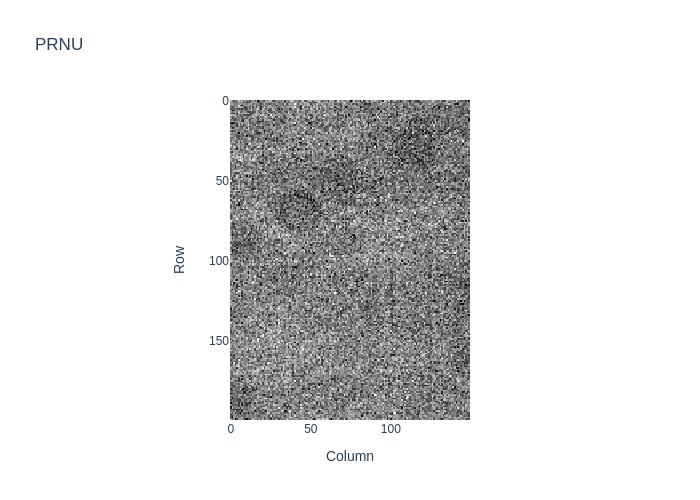

In [16]:
plotter.rowcolumn(prnu_img,
                  np.max([0, (np.median(prnu_img) - 3 * np.std(prnu_img))]), 
                  np.median(prnu_img) + 3 * np.std(prnu_img),
                  title='PRNU')

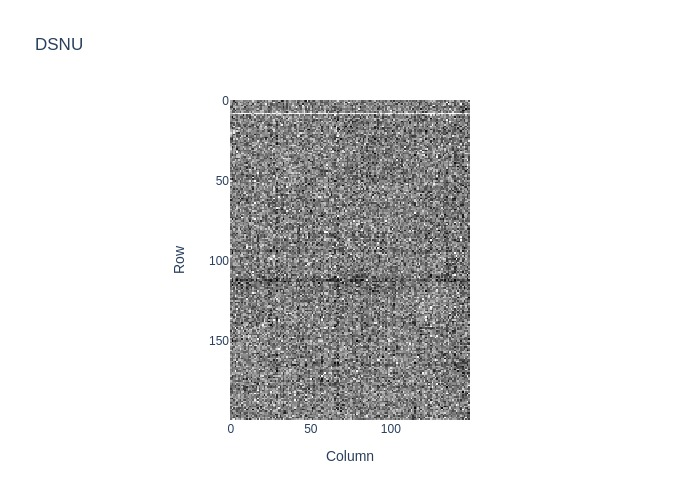

In [17]:
plotter.rowcolumn(dark_avg_img,
                  np.max([0, (np.median(dark_avg_img) - 3 * np.std(dark_avg_img))]), 
                  np.median(dark_avg_img) + 3 * np.std(dark_avg_img),
                  title='DSNU')

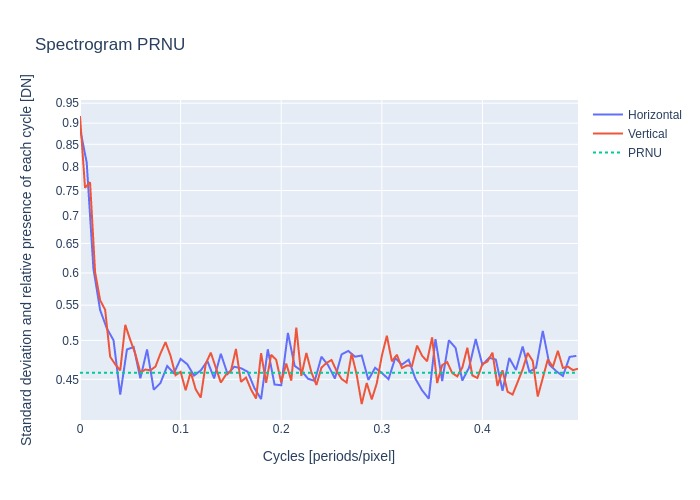

In [18]:
plotter.spectrogram(spect['PRNU1288'], 
                    summ['Total PRNU1288 [%]'][0], 
                    'PRNU')

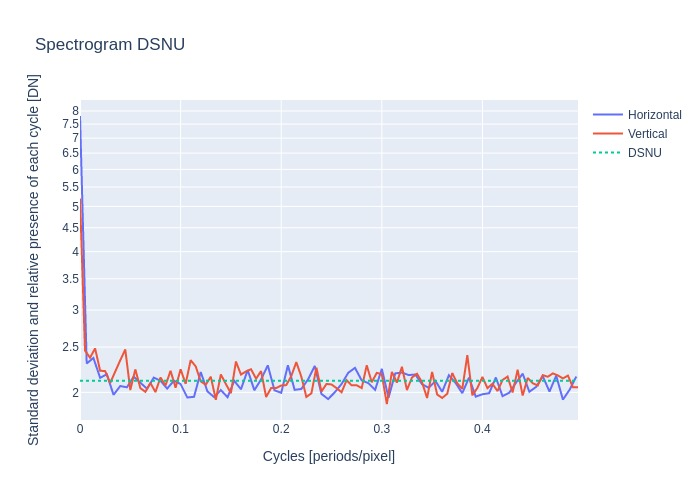

In [19]:
plotter.spectrogram(spect['DSNU1288'], 
                    summ['Total DSNU [DN]'][0], 
                    'DSNU')

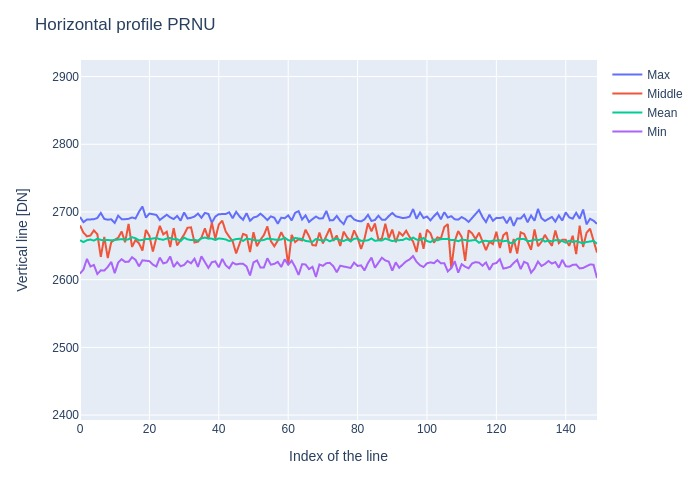

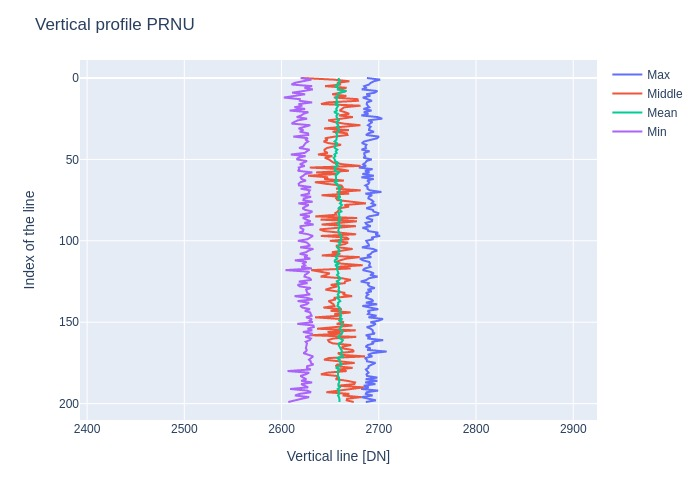

In [20]:
plotter.multi_profile(profiles['PRNU1288'],
                      param = 'PRNU',
                      orientation = 'Horizontal')
plotter.multi_profile(profiles['PRNU1288'],
                      param = 'PRNU',
                      orientation = 'Vertical')

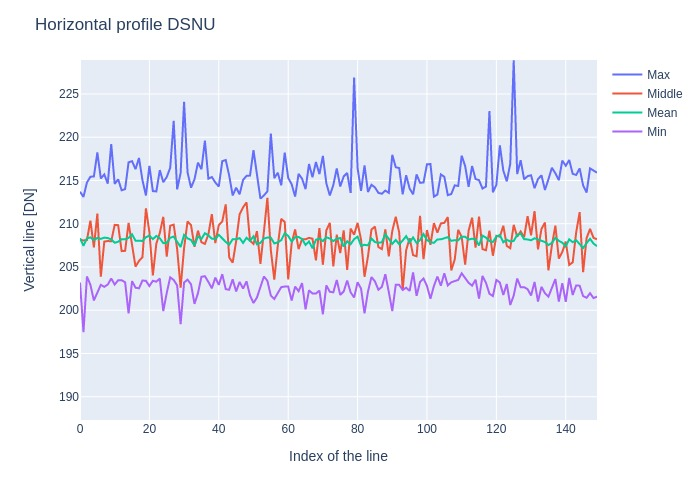

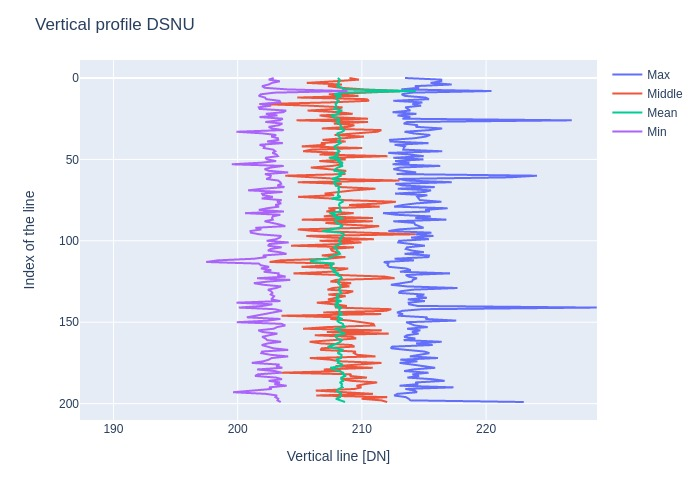

In [21]:
plotter.multi_profile(profiles['DSNU1288'],
                      param = 'DSNU',
                      orientation = 'Horizontal')
plotter.multi_profile(profiles['DSNU1288'],
                      param = 'DSNU',
                      orientation = 'Vertical')

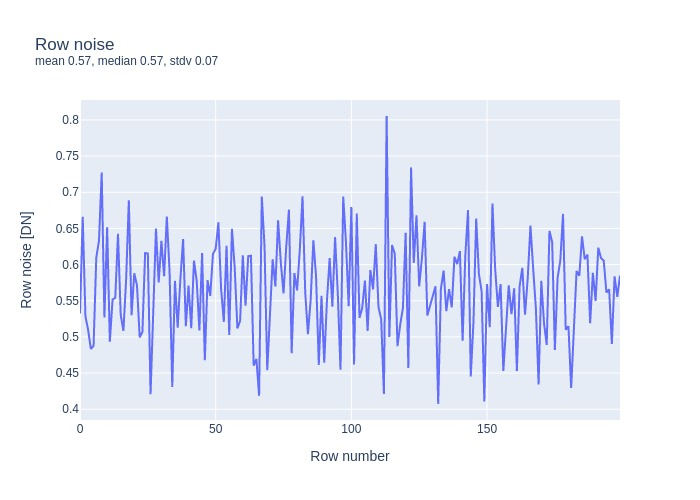

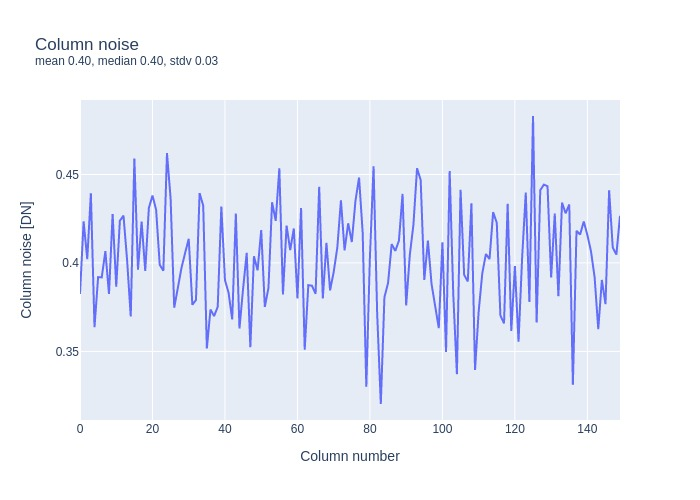

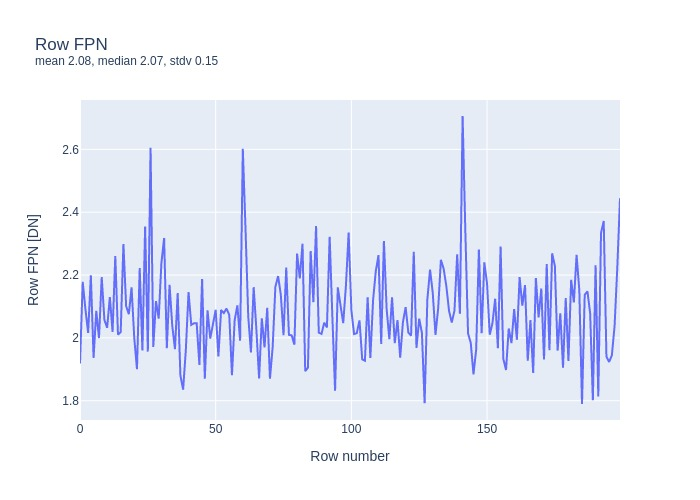

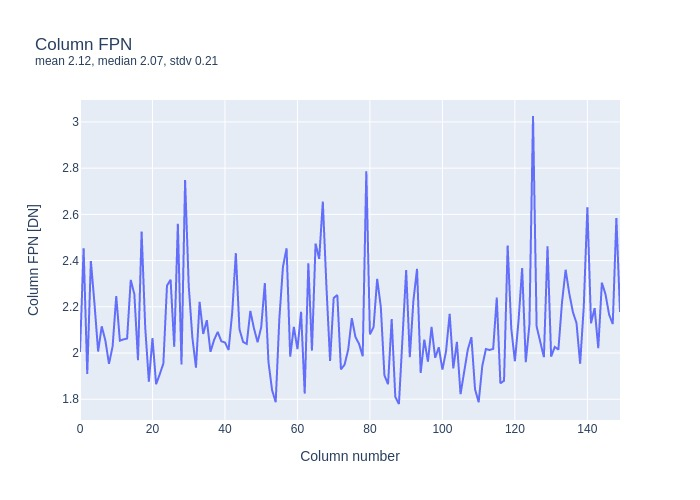

In [22]:
plotter.profile(stats.noise_profile(dark_imgs, axis='row'),
                axis='Row', quantity='noise', unit='DN')
plotter.profile(stats.noise_profile(dark_imgs, axis='column'),
                axis='Column', quantity='noise', unit='DN')
plotter.profile(stats.fpn_profile(dark_imgs, axis='row'),
                axis='Row', quantity='FPN', unit='DN')
plotter.profile(stats.fpn_profile(dark_imgs, axis='column'),
                axis='Column', quantity='FPN', unit='DN')

In [23]:
# fig = px.line(data.iloc[1: , :], x='Mean Signal [e]' , y=['SNR [dB]', 'SNR Ideal [dB]', 'SNR Theoretical [dB]'], 
#               title='SNR')
# fig.update_xaxes(type="log")
# fig.show()

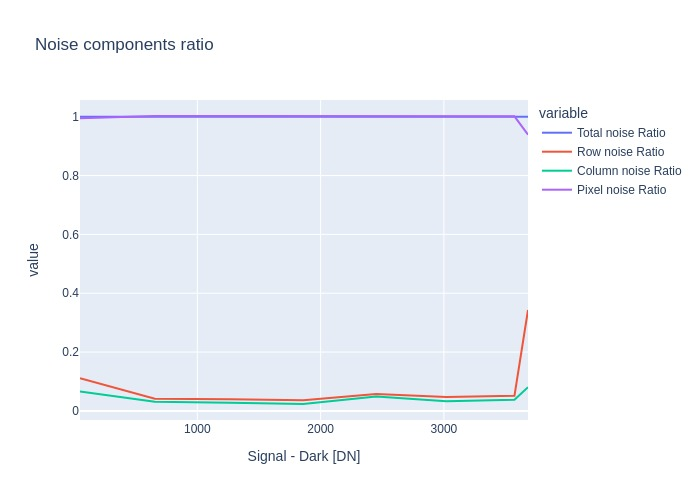

In [24]:
temp = pd.DataFrame()
temp['Signal - Dark [DN]'] = data['Signal - Dark [DN]']
temp['Total noise Ratio'] = np.sqrt(data['Tot Temp Var [DN^2]']) / np.sqrt(data['Tot Temp Var [DN^2]'])
temp['Row noise Ratio'] = np.sqrt(data['Row Temp Var [DN^2]']) / np.sqrt(data['Tot Temp Var [DN^2]'])
temp['Column noise Ratio'] = np.sqrt(data['Col Temp Var [DN^2]']) / np.sqrt(data['Tot Temp Var [DN^2]'])
temp['Pixel noise Ratio'] = np.sqrt(data['Pix Temp Var [DN^2]']) / np.sqrt(data['Tot Temp Var [DN^2]'])

fig = px.line(temp.iloc[1: , :], x='Signal - Dark [DN]', y=['Total noise Ratio',  
                                                            'Row noise Ratio', 
                                                            'Column noise Ratio', 
                                                            'Pixel noise Ratio'], 
              title='Noise components ratio')
fig.show()

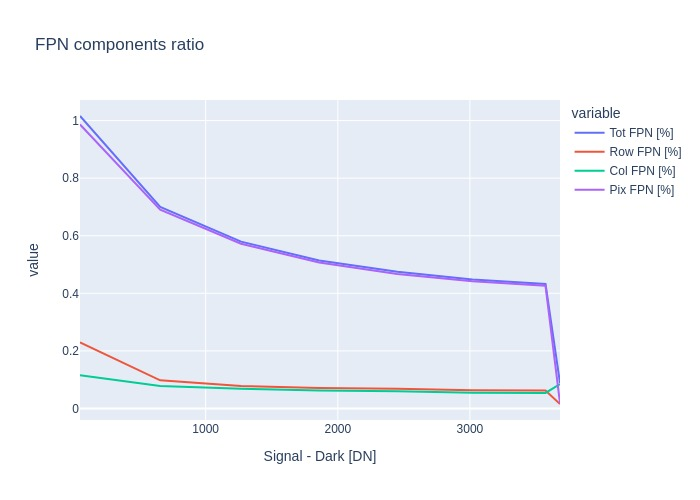

In [25]:
fig = px.line(data.iloc[1: , :], x='Signal - Dark [DN]', y=['Tot FPN [%]', 'Row FPN [%]', 'Col FPN [%]', 'Pix FPN [%]'], 
              title='FPN components ratio')
fig.show()

### Save data

In [26]:
if save_notebook_to_html:
    time.sleep(5)

In [27]:
%%javascript
IPython.notebook.save_checkpoint()
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [28]:
# Save notebook to html
if save_notebook_to_html:
    time.sleep(5)
    path = os.getcwd() + '/'
    if os.path.exists(f'{path + notebook_name}.ipynb'):
        filename = notebook_name + '_notebook'
        
        results_path = path + f'results{datestr}/'
        if not os.path.exists(results_path):
            os.makedirs(results_path)
            
        !jupyter nbconvert --to html {notebook_name}.ipynb --output {results_path + filename}.html
    else: 
        print('Please provide the correct notebook name!')

In [29]:
# save results to excel
if save_results_to_excel:
    filename = notebook_name + '_excel'
    
    path = os.getcwd() + '/'
    results_path = path + f'results{datestr}/'
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    with pd.ExcelWriter(f'{results_path + filename}.xlsx') as writer:  
        data.to_excel(writer, sheet_name='data')
        
        summ.to_excel(writer, sheet_name='summ')
        
        hist_DSNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in hist['DSNU1288'].items()]))
        hist_DSNU.to_excel(writer, sheet_name='hist_DSNU')
        
        hist_PRNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in hist['PRNU1288'].items()]))
        hist_PRNU.to_excel(writer, sheet_name='hist_PRNU')
        
        hist_TDN = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in hist_tdn.items()]))
        hist_TDN.to_excel(writer, sheet_name='hist_TDN')
        
        profiles_DSNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in profiles['DSNU1288'].items()]))
        profiles_DSNU.to_excel(writer, sheet_name='profiles_DSNU')
        
        profiles_PRNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in profiles['PRNU1288'].items()]))
        profiles_PRNU.to_excel(writer, sheet_name='profiles_PRNU')
        
        spect_DSNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in spect['DSNU1288'].items()]))
        spect_DSNU.to_excel(writer, sheet_name='spect_DSNU')
        
        spect_PRNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in spect['PRNU1288'].items()]))
        spect_PRNU.to_excel(writer, sheet_name='spect_PRNU')